# <날씨예측>

# 1. 서론

## 동기 및 프로젝트 방향성

최근 환절기로 기후의 변화가 많이 일어납니다. \
빨래나 환기등을 위해 창문을 열어놓는 일이 잦아졌는데, 이를 위해서는 비가 오는지를 확인해 보아야합니다. 하지만, 2일전까지만 해도 비가 오지 않는다던 기상예보가 당일이되면 비가오는 경우가 많습니다. \
\
저는 이를 계기로 날씨를 예측하는 것이 얼마나 어려운지 지역에 따라 알아볼 예정입니다.\
지역은 내륙 지역인 서울, 해안가인 울산, 거주중인 양산 총 세 지역으로 나누어 분석을 진행하였습니다.\
또한, 날씨 중에서도 우리와 가장 밀접한 '비'에 대해서 집중적으로 분석을 해보려 합니다.\
총 두가지, 비가 오는지 안오는지와 강수량에 대한 모델을 구상해 볼 계획입니다.\
\
그리고 이렇게 알아본 바를 이용하여 각각의 변수를 입력하였을 때, 비의 강수량을 예측하는 프로그램을 만들어볼 예정입니다.

## 필요 라이브러리 불러오기

In [1]:
!pip install IPython

In [2]:
import sys
import glob
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
from IPython.display import Image

from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

import statsmodels.formula.api as smf
import statsmodels.api as sm

%precision 3
%matplotlib inline

## 데이터 불러오기 및 필요한 변수만 가져오기

### 데이터 불러오기

In [3]:
#서울 데이터
seoul_18 = pd.read_excel("서울_186.xlsx", header = 0)
seoul_19 = pd.read_excel("서울_196.xlsx", header = 0)
seoul_20 = pd.read_excel("서울_206.xlsx", header = 0)

#울산 데이터
ulsan_18 = pd.read_excel("울산_186.xlsx", header = 0)
ulsan_19 = pd.read_excel("울산_196.xlsx", header = 0)
ulsan_20 = pd.read_excel("울산_206.xlsx", header = 0)

#양산 데이터
yangsan_18 = pd.read_excel("양산_186.xlsx", header = 0)
yangsan_19 = pd.read_excel("양산_196.xlsx", header = 0)
yangsan_20 = pd.read_excel("양산_206.xlsx", header = 0)

### 파일 지역별로 병합하기

In [4]:
seoul = pd.concat([seoul_18, seoul_19, seoul_20])
ulsan = pd.concat([ulsan_18, ulsan_19, ulsan_20])
yangsan = pd.concat([yangsan_18, yangsan_19, yangsan_20])

seoul.index = seoul.일시
ulsan.index = ulsan.일시
yangsan.index = yangsan.일시

### 필요한 변수 제외 제외 및 정리하기

각각의 QC플래그는 품질검사를 수행한 결과를 나타내고 있습니다. 값으로는 0, 1, 9, nan가 있는데 0만이 검사결과가 좋다고 할 수 있는데 자료에서 그 수가 적어 모두 옳은 값이라는 가정을 두고 모델을 만들 예정입니다.\
또한, 운형은 수치형이 아니기에 제외하였습니다.

In [5]:
seoul = seoul.drop(['지점', '지점명','일시', '지면상태(지면상태코드)', '기온 QC플래그', '강수량 QC플래그',
                    '풍속 QC플래그', '풍향 QC플래그', '습도 QC플래그', '현지기압 QC플래그', '해면기압 QC플래그', 
                    '일조 QC플래그', '지면온도 QC플래그', '운형(운형약어)'], axis = 1)
ulsan = ulsan.drop(['지점', '지점명','일시', '지면상태(지면상태코드)', '기온 QC플래그', '강수량 QC플래그',
                    '풍속 QC플래그', '풍향 QC플래그', '습도 QC플래그', '현지기압 QC플래그', '해면기압 QC플래그', 
                    '일조 QC플래그', '지면온도 QC플래그', '운형(운형약어)'], axis = 1)
yangsan = yangsan.drop(['지점', '지점명','일시', '지면상태(지면상태코드)', '기온 QC플래그', '강수량 QC플래그',
                    '풍속 QC플래그', '풍향 QC플래그', '습도 QC플래그', '현지기압 QC플래그', '해면기압 QC플래그', 
                    '일조 QC플래그', '지면온도 QC플래그', '운형(운형약어)'], axis = 1)

In [6]:
seoul.columns = ['temperature', 'rain_amount', 'wind_speed', 'wind_direction', 'humidity', 'vapor_pressure', 'dew_point_temperature', 
               'local_pressure', 'sea_level_pressure', 'sunshine', 'solar', 'snow_cover', '3_hour_new_snow', 'total_amount_of_cloud', 
               'low_middle_level_clouds', 'minimum_cloud_height', 'visibility', 'phenomenon_number', 'ground_temperature', 
               'ground_temperature_5cm', 'ground_temperature_10cm', 'ground_temperature_20cm', 'ground_temperature_30cm']
ulsan.columns = ['temperature', 'rain_amount', 'wind_speed', 'wind_direction', 'humidity', 'vapor_pressure', 'dew_point_temperature', 
               'local_pressure', 'sea_level_pressure', 'sunshine', 'solar', 'snow_cover', '3_hour_new_snow', 'total_amount_of_cloud', 
               'low_middle_level_clouds', 'minimum_cloud_height', 'visibility', 'phenomenon_number', 'ground_temperature', 
               'ground_temperature_5cm', 'ground_temperature_10cm', 'ground_temperature_20cm', 'ground_temperature_30cm']
yangsan.columns = ['temperature', 'rain_amount', 'wind_speed', 'wind_direction', 'humidity', 'vapor_pressure', 'dew_point_temperature', 
               'local_pressure', 'sea_level_pressure', 'sunshine', 'solar', 'snow_cover', '3_hour_new_snow', 'total_amount_of_cloud', 
               'low_middle_level_clouds', 'minimum_cloud_height', 'visibility', 'phenomenon_number', 'ground_temperature', 
               'ground_temperature_5cm', 'ground_temperature_10cm', 'ground_temperature_20cm', 'ground_temperature_30cm']

비가 오는지 안오는지와 강수량이 어느정도 오는지를 확인해 보려 합니다. \
전자는 범주형이기에 로지스틱 회귀를 사용하고, 후자는 연속형이기에 선형회귀모델을 사용하도록 하겠습니다.\
\
아래는 전자를 실행하기 위해 비의 유무를 나타내는 column을 만드는 code입니다.

In [7]:
seoul['rain'] = np.where(seoul['rain_amount']>0, 1, 0)
ulsan['rain'] = np.where(ulsan['rain_amount']>0, 1, 0)
yangsan['rain'] = np.where(yangsan['rain_amount']>0, 1, 0)

In [8]:
seoul = seoul.fillna(0)
ulsan = ulsan.fillna(0)
yangsan = yangsan.fillna(0)

# 2. 본론

모든 변수를 포함한 모델을 형성한 뒤, 각 변수의 p값을 구하여 0.05보다 큰 값은 제외하고 모델을 만들 계획입니다.

## 2-1. 비의 유무 예측

### 1-1) 단일 독립변수

In [9]:
seoul_temperature = smf.glm(formula = "rain ~ temperature", data = seoul, family = sm.families.Binomial()).fit()
seoul_wind_speed = smf.glm(formula = "rain ~ wind_speed", data = seoul, family = sm.families.Binomial()).fit()
seoul_wind_direction = smf.glm(formula = "rain ~ wind_direction", data = seoul, family = sm.families.Binomial()).fit()
seoul_humidity = smf.glm(formula = "rain ~ humidity", data = seoul, family = sm.families.Binomial()).fit()
seoul_vapor_pressure = smf.glm(formula = "rain ~ vapor_pressure", data = seoul, family = sm.families.Binomial()).fit()
seoul_dew_point_temperature = smf.glm(formula = "rain ~ dew_point_temperature", data = seoul, family = sm.families.Binomial()).fit()
seoul_local_pressure = smf.glm(formula = "rain ~ local_pressure", data = seoul, family = sm.families.Binomial()).fit()
seoul_sea_level_pressure = smf.glm(formula = "rain ~ sea_level_pressure", data = seoul, family = sm.families.Binomial()).fit()
seoul_sunshine = smf.glm(formula = "rain ~ sunshine", data = seoul, family = sm.families.Binomial()).fit()
seoul_solar = smf.glm(formula = "rain ~ solar", data = seoul, family = sm.families.Binomial()).fit()
seoul_total_amount_of_cloud = smf.glm(formula = "rain ~ total_amount_of_cloud", data = seoul, family = sm.families.Binomial()).fit()
seoul_low_middle_level_clouds = smf.glm(formula = "rain ~ low_middle_level_clouds", data = seoul, family = sm.families.Binomial()).fit()
seoul_minimum_cloud_height = smf.glm(formula = "rain ~ minimum_cloud_height", data = seoul, family = sm.families.Binomial()).fit()
seoul_visibility = smf.glm(formula = "rain ~ visibility", data = seoul, family = sm.families.Binomial()).fit()
seoul_ground_temperature = smf.glm(formula = "rain ~ ground_temperature", data = seoul, family = sm.families.Binomial()).fit()
seoul_ground_temperature_5cm = smf.glm(formula = "rain ~ ground_temperature_5cm", data = seoul, family = sm.families.Binomial()).fit()
seoul_ground_temperature_10cm = smf.glm(formula = "rain ~ ground_temperature_10cm", data = seoul, family = sm.families.Binomial()).fit()
seoul_ground_temperature_20cm = smf.glm(formula = "rain ~ ground_temperature_20cm", data = seoul, family = sm.families.Binomial()).fit()
seoul_ground_temperature_30cm = smf.glm(formula = "rain ~ ground_temperature_30cm", data = seoul, family = sm.families.Binomial()).fit()


ulsan_temperature = smf.glm(formula = "rain ~ temperature", data = ulsan, family = sm.families.Binomial()).fit()
ulsan_wind_speed = smf.glm(formula = "rain ~ wind_speed", data = ulsan, family = sm.families.Binomial()).fit()
ulsan_wind_direction = smf.glm(formula = "rain ~ wind_direction", data = ulsan, family = sm.families.Binomial()).fit()
ulsan_humidity = smf.glm(formula = "rain ~ humidity", data = ulsan, family = sm.families.Binomial()).fit()
ulsan_vapor_pressure = smf.glm(formula = "rain ~ vapor_pressure", data = ulsan, family = sm.families.Binomial()).fit()
ulsan_dew_point_temperature = smf.glm(formula = "rain ~ dew_point_temperature", data = ulsan, family = sm.families.Binomial()).fit()
ulsan_local_pressure = smf.glm(formula = "rain ~ local_pressure", data = ulsan, family = sm.families.Binomial()).fit()
ulsan_sea_level_pressure = smf.glm(formula = "rain ~ sea_level_pressure", data = ulsan, family = sm.families.Binomial()).fit()
ulsan_sunshine = smf.glm(formula = "rain ~ sunshine", data = ulsan, family = sm.families.Binomial()).fit()
ulsan_solar = smf.glm(formula = "rain ~ solar", data = ulsan, family = sm.families.Binomial()).fit()
ulsan_total_amount_of_cloud = smf.glm(formula = "rain ~ total_amount_of_cloud", data = ulsan, family = sm.families.Binomial()).fit()
ulsan_low_middle_level_clouds = smf.glm(formula = "rain ~ low_middle_level_clouds", data = ulsan, family = sm.families.Binomial()).fit()
ulsan_minimum_cloud_height = smf.glm(formula = "rain ~ minimum_cloud_height", data = ulsan, family = sm.families.Binomial()).fit()
ulsan_visibility = smf.glm(formula = "rain ~ visibility", data = ulsan, family = sm.families.Binomial()).fit()
ulsan_ground_temperature = smf.glm(formula = "rain ~ ground_temperature", data = ulsan, family = sm.families.Binomial()).fit()
ulsan_ground_temperature_5cm = smf.glm(formula = "rain ~ ground_temperature_5cm", data = ulsan, family = sm.families.Binomial()).fit()
ulsan_ground_temperature_10cm = smf.glm(formula = "rain ~ ground_temperature_10cm", data = ulsan, family = sm.families.Binomial()).fit()
ulsan_ground_temperature_20cm = smf.glm(formula = "rain ~ ground_temperature_20cm", data = ulsan, family = sm.families.Binomial()).fit()
ulsan_ground_temperature_30cm = smf.glm(formula = "rain ~ ground_temperature_30cm", data = ulsan, family = sm.families.Binomial()).fit()


yangsan_temperature = smf.glm(formula = "rain ~ temperature", data = yangsan, family = sm.families.Binomial()).fit()
yangsan_wind_speed = smf.glm(formula = "rain ~ wind_speed", data = yangsan, family = sm.families.Binomial()).fit()
yangsan_wind_direction = smf.glm(formula = "rain ~ wind_direction", data = yangsan, family = sm.families.Binomial()).fit()
yangsan_humidity = smf.glm(formula = "rain ~ humidity", data = yangsan, family = sm.families.Binomial()).fit()
yangsan_vapor_pressure = smf.glm(formula = "rain ~ vapor_pressure", data = yangsan, family = sm.families.Binomial()).fit()
yangsan_dew_point_temperature = smf.glm(formula = "rain ~ dew_point_temperature", data = yangsan, family = sm.families.Binomial()).fit()
yangsan_local_pressure = smf.glm(formula = "rain ~ local_pressure", data = yangsan, family = sm.families.Binomial()).fit()
yangsan_sea_level_pressure = smf.glm(formula = "rain ~ sea_level_pressure", data = yangsan, family = sm.families.Binomial()).fit()
yangsan_sunshine = smf.glm(formula = "rain ~ sunshine", data = yangsan, family = sm.families.Binomial()).fit()
yangsan_solar = smf.glm(formula = "rain ~ solar", data = yangsan, family = sm.families.Binomial()).fit()
yangsan_total_amount_of_cloud = smf.glm(formula = "rain ~ total_amount_of_cloud", data = yangsan, family = sm.families.Binomial()).fit()
yangsan_low_middle_level_clouds = smf.glm(formula = "rain ~ low_middle_level_clouds", data = yangsan, family = sm.families.Binomial()).fit()
yangsan_minimum_cloud_height = smf.glm(formula = "rain ~ minimum_cloud_height", data = yangsan, family = sm.families.Binomial()).fit()
yangsan_visibility = smf.glm(formula = "rain ~ visibility", data = yangsan, family = sm.families.Binomial()).fit()
yangsan_ground_temperature = smf.glm(formula = "rain ~ ground_temperature", data = yangsan, family = sm.families.Binomial()).fit()
yangsan_ground_temperature_5cm = smf.glm(formula = "rain ~ ground_temperature_5cm", data = yangsan, family = sm.families.Binomial()).fit()
yangsan_ground_temperature_10cm = smf.glm(formula = "rain ~ ground_temperature_10cm", data = yangsan, family = sm.families.Binomial()).fit()
yangsan_ground_temperature_20cm = smf.glm(formula = "rain ~ ground_temperature_20cm", data = yangsan, family = sm.families.Binomial()).fit()
yangsan_ground_temperature_30cm = smf.glm(formula = "rain ~ ground_temperature_30cm", data = yangsan, family = sm.families.Binomial()).fit()

C:\Users\pjwlo\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:894: RuntimeWarning: divide by zero encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))


### 1-2) 각 독립변수에 대한 AIC값

In [10]:
seoul_aic = [seoul_temperature.aic, seoul_wind_speed.aic, seoul_wind_direction.aic, seoul_humidity.aic, seoul_vapor_pressure.aic, 
             seoul_dew_point_temperature.aic, seoul_local_pressure.aic, seoul_sea_level_pressure.aic, seoul_sunshine.aic, 
             seoul_solar.aic, seoul_total_amount_of_cloud.aic, seoul_low_middle_level_clouds.aic, seoul_minimum_cloud_height.aic, 
             seoul_visibility.aic, seoul_ground_temperature.aic, seoul_ground_temperature_5cm.aic, seoul_ground_temperature_10cm.aic, 
             seoul_ground_temperature_20cm.aic, seoul_ground_temperature_30cm.aic]

ulsan_aic = [ulsan_temperature.aic, ulsan_wind_speed.aic, ulsan_wind_direction.aic, ulsan_humidity.aic, ulsan_vapor_pressure.aic, 
             ulsan_dew_point_temperature.aic, ulsan_local_pressure.aic, ulsan_sea_level_pressure.aic, ulsan_sunshine.aic, 
             ulsan_solar.aic, ulsan_total_amount_of_cloud.aic, ulsan_low_middle_level_clouds.aic, ulsan_minimum_cloud_height.aic, 
             ulsan_visibility.aic, ulsan_ground_temperature.aic, ulsan_ground_temperature_5cm.aic, ulsan_ground_temperature_10cm.aic, 
             ulsan_ground_temperature_20cm.aic, ulsan_ground_temperature_30cm.aic]

yangsan_aic = [yangsan_temperature.aic, yangsan_wind_speed.aic, yangsan_wind_direction.aic, yangsan_humidity.aic, 
               yangsan_vapor_pressure.aic, yangsan_dew_point_temperature.aic, yangsan_local_pressure.aic, yangsan_sea_level_pressure.aic, 
               yangsan_sunshine.aic, yangsan_solar.aic, yangsan_total_amount_of_cloud.aic, yangsan_low_middle_level_clouds.aic, 
               yangsan_minimum_cloud_height.aic, yangsan_visibility.aic, yangsan_ground_temperature.aic, 
               yangsan_ground_temperature_5cm.aic, yangsan_ground_temperature_10cm.aic, yangsan_ground_temperature_20cm.aic, 
               yangsan_ground_temperature_30cm.aic]

C:\Users\pjwlo\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:946: RuntimeWarning: divide by zero encountered in true_divide
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu)) +
C:\Users\pjwlo\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:946: RuntimeWarning: invalid value encountered in multiply
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu)) +
C:\Users\pjwlo\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:947: RuntimeWarning: divide by zero encountered in log
  n * np.log(1 - mu)) * var_weights


In [11]:
small1 = min(seoul_aic)
big1 = max(seoul_aic)
for i in range(len(seoul_aic)):
    if seoul_aic[i] == small1:
        print(i+1, seoul_aic[i],'   smallest')
    elif seoul_aic[i] == big1:
        print(i+1, seoul_aic[i], '   biggest')
    else:
        print(i+1, seoul_aic[i])

1 11947.204547759058
2 12287.321730056678    biggest
3 12076.975329096138
4 6825.274566793541    smallest
5 10451.90098050625
6 10349.901025947138
7 12229.680229609043
8 12220.771628355704
9 11142.161173328175
10 11662.972616081268
11 7504.262559173129
12 9785.693528716747
13 12277.860072691485
14 10625.328923506635
15 12177.254047082268
16 11893.235406592448
17 11763.71715709483
18 11679.903826240887
19 11607.343052190523


In [12]:
small2 = min(ulsan_aic)
big2 = max(ulsan_aic)
for i in range(len(ulsan_aic)):
    if ulsan_aic[i] == small2:
        print(i+1, ulsan_aic[i],'   smallest')
    elif ulsan_aic[i] == big2:
        print(i+1, ulsan_aic[i], '   biggest')
    else:
        print(i+1, ulsan_aic[i])

1 12789.667092571392
2 13079.983369553409
3 13075.42026699567
4 7821.066480688661
5 11807.296610757754
6 11493.025843489104
7 nan
8 nan
9 11699.832730676619
10 13104.753150328801    biggest
11 7722.85027734304    smallest
12 10242.78569640146
13 13029.185316857662
14 10406.9330529217
15 12838.564360981189
16 13104.753150328801    biggest
17 13104.753150328801    biggest
18 13104.753150328801    biggest
19 13104.753150328801    biggest


In [13]:
small3 = min(yangsan_aic)
big3 = max(yangsan_aic)
for i in range(len(yangsan_aic)):
    if yangsan_aic[i] == small3:
        print(i+1, yangsan_aic[i],'   smallest')
    elif yangsan_aic[i] == big3:
        print(i+1, yangsan_aic[i], '   biggest')
    else:
        print(i+1, yangsan_aic[i])

1 11994.78991249017
2 12149.933011462612
3 12111.022493700917
4 7767.920585760811    smallest
5 10880.40067181511
6 10648.227457558523
7 12330.240593618304    biggest
8 12328.743041901038
9 11185.528694943177
10 11774.636469185321
11 10706.957652270961
12 11834.551542160107
13 12282.293063394556
14 11380.616178548124
15 12181.299105140788
16 11989.490440474538
17 11976.757743680517
18 11840.38483410067
19 11769.163867587771


In [14]:
seoul_array= (['humidity', 'total_amount_of_cloud', 'low_middle_level_clouds', 'dew_point_temperature', 'vapor_pressure', 'visibility', 
               'sunshine', 'ground_temperature_30cm', 'solar', 'ground_temperature_20cm', 'ground_temperature_10cm', 
               'ground_temperature_5cm', 'temperature', 'wind_direction', 'ground_temperature', 'sea_level_pressure', 'local_pressure', 
               'minimum_cloud_height', 'wind_speed'])

ulsan_array = (['total_amount_of_cloud', 'humidity', 'low_middle_level_clouds', 'visibility', 'dew_point_temperature', 'sunshine', 
                'vapor_pressure', 'temperature', 'ground_temperature', 'minimum_cloud_height', 'wind_direction', 'wind_speed', ('solar', 
                 'ground_temperature_5cm', 'ground_temperature_10cm', 'ground_temperature_20cm', 'ground_temperature_30cm'), '', '', '', 
                '', '', ''])

yangsan_array = (['humidity', 'dew_point_temperature', 'total_amount_of_cloud', 'vapor_pressure', 'sunshine', 'visibility', 
                  'ground_temperature_30cm', 'solar', 'low_middle_level_clouds', 'ground_temperature_20cm', 'ground_temperature_10cm', 
                  'ground_temperature_5cm', 'temperature', 'wind_direction', 'wind_speed', 'ground_temperature', 'minimum_cloud_height', 
                  'sea_level_pressure', 'local_pressure'])

In [15]:
dict_region = {'seoul':seoul_array, 'ulsan': ulsan_array, 'yangsan': yangsan_array}
display(pd.DataFrame(dict_region))

,seoul,ulsan,yangsan
0,humidity,total_amount_of_cloud,humidity
1,total_amount_of_cloud,humidity,dew_point_temperature
2,low_middle_level_clouds,low_middle_level_clouds,total_amount_of_cloud
3,dew_point_temperature,visibility,vapor_pressure
4,vapor_pressure,dew_point_temperature,sunshine
5,visibility,sunshine,visibility
6,sunshine,vapor_pressure,ground_temperature_30cm
7,ground_temperature_30cm,temperature,solar
8,solar,ground_temperature,low_middle_level_clouds
9,ground_temperature_20cm,minimum_cloud_height,ground_temperature_20cm


변수에 대한 분석은 강수량에서 하도록 하겠습니다.

### 1-3) AIC를 기준으로 모델 생성
null 모델부터 시작하여 AIC값이 작은것부터 차례로 변수를 더해가며 모델을 만들었습니다.

In [16]:
seoul_null = smf.glm(formula = "rain ~ 1", data = seoul, family = sm.families.Binomial()).fit()
seoul1 = smf.glm(formula = "rain ~ humidity", data = seoul, family = sm.families.Binomial()).fit()
seoul2 = smf.glm(formula = "rain ~ humidity + total_amount_of_cloud", data = seoul, family = sm.families.Binomial()).fit()
seoul3 = smf.glm(formula = "rain ~ humidity + total_amount_of_cloud + low_middle_level_clouds", data = seoul, family = sm.families.Binomial()).fit()
seoul4 = smf.glm(formula = "rain ~ humidity + total_amount_of_cloud + low_middle_level_clouds + dew_point_temperature", data = seoul, family = sm.families.Binomial()).fit()
seoul5 = smf.glm(formula = "rain ~ humidity + total_amount_of_cloud + low_middle_level_clouds + dew_point_temperature + vapor_pressure", data = seoul, family = sm.families.Binomial()).fit()
seoul6 = smf.glm(formula = "rain ~ humidity + total_amount_of_cloud + low_middle_level_clouds + dew_point_temperature + vapor_pressure + visibility", data = seoul, family = sm.families.Binomial()).fit()
seoul7 = smf.glm(formula = "rain ~ humidity + total_amount_of_cloud + low_middle_level_clouds + dew_point_temperature + vapor_pressure + visibility + sunshine", data = seoul, family = sm.families.Binomial()).fit()
seoul8 = smf.glm(formula = "rain ~ humidity + total_amount_of_cloud + low_middle_level_clouds + dew_point_temperature + vapor_pressure + visibility + sunshine + ground_temperature_30cm", data = seoul, family = sm.families.Binomial()).fit()
seoul9 = smf.glm(formula = "rain ~ humidity + total_amount_of_cloud + low_middle_level_clouds + dew_point_temperature + vapor_pressure + visibility + sunshine + ground_temperature_30cm + solar", data = seoul, family = sm.families.Binomial()).fit()
seoul10 = smf.glm(formula = "rain ~ humidity + total_amount_of_cloud + low_middle_level_clouds + dew_point_temperature + vapor_pressure + visibility + sunshine + ground_temperature_30cm + solar + ground_temperature_20cm", data = seoul, family = sm.families.Binomial()).fit()
seoul11 = smf.glm(formula = "rain ~ humidity + total_amount_of_cloud + low_middle_level_clouds + dew_point_temperature + vapor_pressure + visibility + sunshine + ground_temperature_30cm + solar + ground_temperature_20cm + ground_temperature_10cm", data = seoul, family = sm.families.Binomial()).fit()
seoul12 = smf.glm(formula = "rain ~ humidity + total_amount_of_cloud + low_middle_level_clouds + dew_point_temperature + vapor_pressure + visibility + sunshine + ground_temperature_30cm + solar + ground_temperature_20cm + ground_temperature_10cm + ground_temperature_5cm", data = seoul, family = sm.families.Binomial()).fit()
seoul13 = smf.glm(formula = "rain ~ humidity + total_amount_of_cloud + low_middle_level_clouds + dew_point_temperature + vapor_pressure + visibility + sunshine + ground_temperature_30cm + solar + ground_temperature_20cm + ground_temperature_10cm + ground_temperature_5cm + temperature", data = seoul, family = sm.families.Binomial()).fit()
seoul14 = smf.glm(formula = "rain ~ humidity + total_amount_of_cloud + low_middle_level_clouds + dew_point_temperature + vapor_pressure + visibility + sunshine + ground_temperature_30cm + solar + ground_temperature_20cm + ground_temperature_10cm + ground_temperature_5cm + temperature + wind_direction", data = seoul, family = sm.families.Binomial()).fit()
seoul15 = smf.glm(formula = "rain ~ humidity + total_amount_of_cloud + low_middle_level_clouds + dew_point_temperature + vapor_pressure + visibility + sunshine + ground_temperature_30cm + solar + ground_temperature_20cm + ground_temperature_10cm + ground_temperature_5cm + temperature + wind_direction + ground_temperature", data = seoul, family = sm.families.Binomial()).fit()
seoul16 = smf.glm(formula = "rain ~ humidity + total_amount_of_cloud + low_middle_level_clouds + dew_point_temperature + vapor_pressure + visibility + sunshine + ground_temperature_30cm + solar + ground_temperature_20cm + ground_temperature_10cm + ground_temperature_5cm + temperature + wind_direction + ground_temperature + sea_level_pressure", data = seoul, family = sm.families.Binomial()).fit()
seoul17 = smf.glm(formula = "rain ~ humidity + total_amount_of_cloud + low_middle_level_clouds + dew_point_temperature + vapor_pressure + visibility + sunshine + ground_temperature_30cm + solar + ground_temperature_20cm + ground_temperature_10cm + ground_temperature_5cm + temperature + wind_direction + ground_temperature + sea_level_pressure + local_pressure", data = seoul, family = sm.families.Binomial()).fit()
seoul18 = smf.glm(formula = "rain ~ humidity + total_amount_of_cloud + low_middle_level_clouds + dew_point_temperature + vapor_pressure + visibility + sunshine + ground_temperature_30cm + solar + ground_temperature_20cm + ground_temperature_10cm + ground_temperature_5cm + temperature + wind_direction + ground_temperature + sea_level_pressure + local_pressure + minimum_cloud_height", data = seoul, family = sm.families.Binomial()).fit()
seoul19 = smf.glm(formula = "rain ~ humidity + total_amount_of_cloud + low_middle_level_clouds + dew_point_temperature + vapor_pressure + visibility + sunshine + ground_temperature_30cm + solar + ground_temperature_20cm + ground_temperature_10cm + ground_temperature_5cm + temperature + wind_direction + ground_temperature + sea_level_pressure + local_pressure + minimum_cloud_height + wind_speed", data = seoul, family = sm.families.Binomial()).fit()

In [17]:
ulsan_null = smf.glm(formula = "rain ~ 1", data = ulsan, family = sm.families.Binomial()).fit()
ulsan1 = smf.glm(formula = "rain ~ total_amount_of_cloud", data = ulsan, family = sm.families.Binomial()).fit()
ulsan2 = smf.glm(formula = "rain ~ total_amount_of_cloud + humidity", data = ulsan, family = sm.families.Binomial()).fit()
ulsan3 = smf.glm(formula = "rain ~ total_amount_of_cloud + humidity + low_middle_level_clouds", data = ulsan, family = sm.families.Binomial()).fit()
ulsan4 = smf.glm(formula = "rain ~ total_amount_of_cloud + humidity + low_middle_level_clouds + visibility", data = ulsan, family = sm.families.Binomial()).fit()
ulsan5 = smf.glm(formula = "rain ~ total_amount_of_cloud + humidity + low_middle_level_clouds + visibility + dew_point_temperature", data = ulsan, family = sm.families.Binomial()).fit()
ulsan6 = smf.glm(formula = "rain ~ total_amount_of_cloud + humidity + low_middle_level_clouds + visibility + dew_point_temperature + sunshine", data = ulsan, family = sm.families.Binomial()).fit()
ulsan7 = smf.glm(formula = "rain ~ total_amount_of_cloud + humidity + low_middle_level_clouds + visibility + dew_point_temperature + sunshine + vapor_pressure", data = ulsan, family = sm.families.Binomial()).fit()
ulsan8 = smf.glm(formula = "rain ~ total_amount_of_cloud + humidity + low_middle_level_clouds + visibility + dew_point_temperature + sunshine + vapor_pressure + temperature", data = ulsan, family = sm.families.Binomial()).fit()
ulsan9 = smf.glm(formula = "rain ~ total_amount_of_cloud + humidity + low_middle_level_clouds + visibility + dew_point_temperature + sunshine + vapor_pressure + temperature + ground_temperature", data = ulsan, family = sm.families.Binomial()).fit()
ulsan10 = smf.glm(formula = "rain ~ total_amount_of_cloud + humidity + low_middle_level_clouds + visibility + dew_point_temperature + sunshine + vapor_pressure + temperature + ground_temperature + minimum_cloud_height", data = ulsan, family = sm.families.Binomial()).fit()
ulsan11 = smf.glm(formula = "rain ~ total_amount_of_cloud + humidity + low_middle_level_clouds + visibility + dew_point_temperature + sunshine + vapor_pressure + temperature + ground_temperature + minimum_cloud_height + wind_direction", data = ulsan, family = sm.families.Binomial()).fit()
ulsan12 = smf.glm(formula = "rain ~ total_amount_of_cloud + humidity + low_middle_level_clouds + visibility + dew_point_temperature + sunshine + vapor_pressure + temperature + ground_temperature + minimum_cloud_height + wind_direction + wind_speed", data = ulsan, family = sm.families.Binomial()).fit()
ulsan13 = smf.glm(formula = "rain ~ total_amount_of_cloud + humidity + low_middle_level_clouds + visibility + dew_point_temperature + sunshine + vapor_pressure + temperature + ground_temperature + minimum_cloud_height + wind_direction + wind_speed + solar + ground_temperature_5cm + ground_temperature_10cm + ground_temperature_20cm + ground_temperature_30cm", data = ulsan, family = sm.families.Binomial()).fit()

C:\Users\pjwlo\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:894: RuntimeWarning: divide by zero encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
C:\Users\pjwlo\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:894: RuntimeWarning: invalid value encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
C:\Users\pjwlo\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:188: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
C:\Users\pjwlo\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:893: RuntimeWarning: divide by zero encountered in true_divide
  endog_mu = self._clean(endog / mu)
C:\Users\pjwlo\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:893: RuntimeWarning: invalid value encountered in true_divide
  endog_mu = self._clean(endog / mu)


In [18]:
yangsan_null = smf.glm(formula = "rain ~ 1", data = yangsan, family = sm.families.Binomial()).fit()
yangsan1 = smf.glm(formula = "rain ~ humidity", data = yangsan, family = sm.families.Binomial()).fit()
yangsan2 = smf.glm(formula = "rain ~ humidity + dew_point_temperature", data = yangsan, family = sm.families.Binomial()).fit()
yangsan3 = smf.glm(formula = "rain ~ humidity + dew_point_temperature + total_amount_of_cloud", data = yangsan, family = sm.families.Binomial()).fit()
yangsan4 = smf.glm(formula = "rain ~ humidity + dew_point_temperature + total_amount_of_cloud + vapor_pressure", data = yangsan, family = sm.families.Binomial()).fit()
yangsan5 = smf.glm(formula = "rain ~ humidity + dew_point_temperature + total_amount_of_cloud + vapor_pressure + sunshine", data = yangsan, family = sm.families.Binomial()).fit()
yangsan6 = smf.glm(formula = "rain ~ humidity + dew_point_temperature + total_amount_of_cloud + vapor_pressure + sunshine + visibility", data = yangsan, family = sm.families.Binomial()).fit()
yangsan7 = smf.glm(formula = "rain ~ humidity + dew_point_temperature + total_amount_of_cloud + vapor_pressure + sunshine + visibility + ground_temperature_30cm", data = yangsan, family = sm.families.Binomial()).fit()
yangsan8 = smf.glm(formula = "rain ~ humidity + dew_point_temperature + total_amount_of_cloud + vapor_pressure + sunshine + visibility + ground_temperature_30cm + solar", data = yangsan, family = sm.families.Binomial()).fit()
yangsan9 = smf.glm(formula = "rain ~ humidity + dew_point_temperature + total_amount_of_cloud + vapor_pressure + sunshine + visibility + ground_temperature_30cm + solar + low_middle_level_clouds", data = yangsan, family = sm.families.Binomial()).fit()
yangsan10 = smf.glm(formula = "rain ~ humidity + dew_point_temperature + total_amount_of_cloud + vapor_pressure + sunshine + visibility + ground_temperature_30cm + solar + low_middle_level_clouds + ground_temperature_20cm", data = yangsan, family = sm.families.Binomial()).fit()
yangsan11 = smf.glm(formula = "rain ~ humidity + dew_point_temperature + total_amount_of_cloud + vapor_pressure + sunshine + visibility + ground_temperature_30cm + solar + low_middle_level_clouds + ground_temperature_20cm + ground_temperature_10cm", data = yangsan, family = sm.families.Binomial()).fit()
yangsan12 = smf.glm(formula = "rain ~ humidity + dew_point_temperature + total_amount_of_cloud + vapor_pressure + sunshine + visibility + ground_temperature_30cm + solar + low_middle_level_clouds + ground_temperature_20cm + ground_temperature_10cm + ground_temperature_5cm", data = yangsan, family = sm.families.Binomial()).fit()
yangsan13 = smf.glm(formula = "rain ~ humidity + dew_point_temperature + total_amount_of_cloud + vapor_pressure + sunshine + visibility + ground_temperature_30cm + solar + low_middle_level_clouds + ground_temperature_20cm + ground_temperature_10cm + ground_temperature_5cm + temperature", data = yangsan, family = sm.families.Binomial()).fit()
yangsan14 = smf.glm(formula = "rain ~ humidity + dew_point_temperature + total_amount_of_cloud + vapor_pressure + sunshine + visibility + ground_temperature_30cm + solar + low_middle_level_clouds + ground_temperature_20cm + ground_temperature_10cm + ground_temperature_5cm + temperature + wind_direction", data = yangsan, family = sm.families.Binomial()).fit()
yangsan15 = smf.glm(formula = "rain ~ humidity + dew_point_temperature + total_amount_of_cloud + vapor_pressure + sunshine + visibility + ground_temperature_30cm + solar + low_middle_level_clouds + ground_temperature_20cm + ground_temperature_10cm + ground_temperature_5cm + temperature + wind_direction + wind_speed", data = yangsan, family = sm.families.Binomial()).fit()
yangsan16 = smf.glm(formula = "rain ~ humidity + dew_point_temperature + total_amount_of_cloud + vapor_pressure + sunshine + visibility + ground_temperature_30cm + solar + low_middle_level_clouds + ground_temperature_20cm + ground_temperature_10cm + ground_temperature_5cm + temperature + wind_direction + wind_speed + ground_temperature", data = yangsan, family = sm.families.Binomial()).fit()
yangsan17 = smf.glm(formula = "rain ~ humidity + dew_point_temperature + total_amount_of_cloud + vapor_pressure + sunshine + visibility + ground_temperature_30cm + solar + low_middle_level_clouds + ground_temperature_20cm + ground_temperature_10cm + ground_temperature_5cm + temperature + wind_direction + wind_speed + ground_temperature + minimum_cloud_height", data = yangsan, family = sm.families.Binomial()).fit()
yangsan18 = smf.glm(formula = "rain ~ humidity + dew_point_temperature + total_amount_of_cloud + vapor_pressure + sunshine + visibility + ground_temperature_30cm + solar + low_middle_level_clouds + ground_temperature_20cm + ground_temperature_10cm + ground_temperature_5cm + temperature + wind_direction + wind_speed + ground_temperature + minimum_cloud_height + sea_level_pressure", data = yangsan, family = sm.families.Binomial()).fit()
yangsan19 = smf.glm(formula = "rain ~ humidity + dew_point_temperature + total_amount_of_cloud + vapor_pressure + sunshine + visibility + ground_temperature_30cm + solar + low_middle_level_clouds + ground_temperature_20cm + ground_temperature_10cm + ground_temperature_5cm + temperature + wind_direction + wind_speed + ground_temperature + minimum_cloud_height + sea_level_pressure + local_pressure", data = yangsan, family = sm.families.Binomial()).fit()

### 1-4) 다변수 모델의 AIC값

In [19]:
complete_seoul_aic = [seoul1.aic, seoul2.aic, seoul3.aic, seoul4.aic, seoul5.aic, seoul6.aic, seoul7.aic, seoul8.aic, seoul9.aic, seoul10.aic,
                  seoul11.aic, seoul12.aic, seoul13.aic, seoul14.aic, seoul15.aic, seoul16.aic, seoul17.aic, seoul18.aic, seoul19.aic]

complete_ulsan_aic = [ulsan1.aic, ulsan2.aic, ulsan3.aic, ulsan4.aic, ulsan5.aic, ulsan6.aic, ulsan7.aic, ulsan8.aic, ulsan9.aic, ulsan10.aic,
                  ulsan11.aic, ulsan12.aic, ulsan13.aic]

complete_yangsan_aic = [yangsan1.aic, yangsan2.aic, yangsan3.aic, yangsan4.aic, yangsan5.aic, yangsan6.aic, yangsan7.aic, yangsan8.aic,
                   yangsan9.aic, yangsan10.aic, yangsan11.aic, yangsan12.aic, yangsan13.aic, yangsan14.aic, yangsan15.aic, yangsan16.aic,
                   yangsan17.aic, yangsan18.aic, yangsan19.aic]

C:\Users\pjwlo\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:946: RuntimeWarning: divide by zero encountered in true_divide
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu)) +
C:\Users\pjwlo\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:946: RuntimeWarning: divide by zero encountered in log
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu)) +
C:\Users\pjwlo\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:946: RuntimeWarning: invalid value encountered in multiply
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu)) +
C:\Users\pjwlo\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:947: RuntimeWarning: divide by zero encountered in log
  n * np.log(1 - mu)) * var_weights
C:\Users\pjwlo\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:947: RuntimeWarning: invalid value encountered in add
  n * np.log(1 - mu)) * var_weights


### 1-5) AIC값이 가장 작은 것을 기준으로 날씨 유무를 예측하는 최종 모델 선정

In [20]:
small4 = min(complete_seoul_aic)
for i in range(len(complete_seoul_aic)):
    if complete_seoul_aic[i] == small4:
        print(i+1, complete_seoul_aic[i],'   smallest')
    else:
        pass

19 5061.5626601321055    smallest


In [21]:
small5 = min(complete_ulsan_aic)
for i in range(len(complete_ulsan_aic)):
    if complete_ulsan_aic[i] == small5:
        print(i+1, complete_ulsan_aic[i],'   smallest')
    else:
        pass

10 5473.074675798038    smallest


In [22]:
small6 = min(complete_yangsan_aic)
for i in range(len(complete_yangsan_aic)):
    if complete_yangsan_aic[i] == small6:
        print(i+1, complete_yangsan_aic[i],'   smallest')
    else:
        pass

12 6629.498921949501    smallest


### 1-6) 예측한 값을 기존값과 비교하기 위한 column추가

In [23]:
seoul_test = seoul19.predict()
seoul['predict'] = np.where(seoul_test > 0.5, 1, 0)
check_seoul = seoul.predict == seoul.rain
seoul['correct'] = check_seoul

In [24]:
ulsan_test = ulsan5.predict()
ulsan['predict'] = np.where(ulsan_test > 0.5, 1, 0)
check_ulsan = ulsan.predict == ulsan.rain
ulsan['correct'] = check_ulsan

In [25]:
yangsan_test = yangsan6.predict()
yangsan['predict'] = np.where(yangsan_test > 0.5, 1, 0)
check_yangsan = yangsan.predict == yangsan.rain
yangsan['correct'] = check_yangsan

### 1-7) 예측의 정확도

In [26]:
seoul_wrong = seoul[seoul['correct']==False]
ulsan_wrong = ulsan[ulsan['correct']==False]
yangsan_wrong = yangsan[yangsan['correct']==False]

In [27]:
print("seoul: ", 100 - len(seoul_wrong)/len(seoul) * 100)
print("ulsan: ", 100 - len(ulsan_wrong)/len(ulsan) * 100)
print("yangsan: ", 100 - len(yangsan_wrong)/len(yangsan) * 100)

seoul:  96.06143552311435
ulsan:  95.09580291970804
yangsan:  94.96274330900243


## 2-2) 강수량 예측

### 2-1) 단일독립 변수

In [28]:
seoul_amount_temperature = smf.glm(formula = "rain_amount ~ temperature", data = seoul, family = sm.families.Poisson()).fit()
seoul_amount_wind_speed = smf.glm(formula = "rain_amount ~ wind_speed", data = seoul, family = sm.families.Poisson()).fit()
seoul_amount_wind_direction = smf.glm(formula = "rain_amount ~ wind_direction", data = seoul, family = sm.families.Poisson()).fit()
seoul_amount_humidity = smf.glm(formula = "rain_amount ~ humidity", data = seoul, family = sm.families.Poisson()).fit()
seoul_amount_vapor_pressure = smf.glm(formula = "rain_amount ~ vapor_pressure", data = seoul, family = sm.families.Poisson()).fit()
seoul_amount_dew_point_temperature = smf.glm(formula = "rain_amount ~ dew_point_temperature", data = seoul, family = sm.families.Poisson()).fit()
seoul_amount_local_pressure = smf.glm(formula = "rain_amount ~ local_pressure", data = seoul, family = sm.families.Poisson()).fit()
seoul_amount_sea_level_pressure = smf.glm(formula = "rain_amount ~ sea_level_pressure", data = seoul, family = sm.families.Poisson()).fit()
seoul_amount_sunshine = smf.glm(formula = "rain_amount ~ sunshine", data = seoul, family = sm.families.Poisson()).fit()
seoul_amount_solar = smf.glm(formula = "rain_amount ~ solar", data = seoul, family = sm.families.Poisson()).fit()
seoul_amount_total_amount_of_cloud = smf.glm(formula = "rain_amount ~ total_amount_of_cloud", data = seoul, family = sm.families.Poisson()).fit()
seoul_amount_low_middle_level_clouds = smf.glm(formula = "rain_amount ~ low_middle_level_clouds", data = seoul, family = sm.families.Poisson()).fit()
seoul_amount_minimum_cloud_height = smf.glm(formula = "rain_amount ~ minimum_cloud_height", data = seoul, family = sm.families.Poisson()).fit()
seoul_amount_visibility = smf.glm(formula = "rain_amount ~ visibility", data = seoul, family = sm.families.Poisson()).fit()
seoul_amount_ground_temperature = smf.glm(formula = "rain_amount ~ ground_temperature", data = seoul, family = sm.families.Poisson()).fit()
seoul_amount_ground_temperature_5cm = smf.glm(formula = "rain_amount ~ ground_temperature_5cm", data = seoul, family = sm.families.Poisson()).fit()
seoul_amount_ground_temperature_10cm = smf.glm(formula = "rain_amount ~ ground_temperature_10cm", data = seoul, family = sm.families.Poisson()).fit()
seoul_amount_ground_temperature_20cm = smf.glm(formula = "rain_amount ~ ground_temperature_20cm", data = seoul, family = sm.families.Poisson()).fit()
seoul_amount_ground_temperature_30cm = smf.glm(formula = "rain_amount ~ ground_temperature_30cm", data = seoul, family = sm.families.Poisson()).fit()


ulsan_amount_temperature = smf.glm(formula = "rain_amount ~ temperature", data = ulsan, family = sm.families.Poisson()).fit()
ulsan_amount_wind_speed = smf.glm(formula = "rain_amount ~ wind_speed", data = ulsan, family = sm.families.Poisson()).fit()
ulsan_amount_wind_direction = smf.glm(formula = "rain_amount ~ wind_direction", data = ulsan, family = sm.families.Poisson()).fit()
ulsan_amount_humidity = smf.glm(formula = "rain_amount ~ humidity", data = ulsan, family = sm.families.Poisson()).fit()
ulsan_amount_vapor_pressure = smf.glm(formula = "rain_amount ~ vapor_pressure", data = ulsan, family = sm.families.Poisson()).fit()
ulsan_amount_dew_point_temperature = smf.glm(formula = "rain_amount ~ dew_point_temperature", data = ulsan, family = sm.families.Poisson()).fit()
ulsan_amount_local_pressure = smf.glm(formula = "rain_amount ~ local_pressure", data = ulsan, family = sm.families.Poisson()).fit()
ulsan_amount_sea_level_pressure = smf.glm(formula = "rain_amount ~ sea_level_pressure", data = ulsan, family = sm.families.Poisson()).fit()
ulsan_amount_sunshine = smf.glm(formula = "rain_amount ~ sunshine", data = ulsan, family = sm.families.Poisson()).fit()
ulsan_amount_solar = smf.glm(formula = "rain_amount ~ solar", data = ulsan, family = sm.families.Poisson()).fit()
ulsan_amount_total_amount_of_cloud = smf.glm(formula = "rain_amount ~ total_amount_of_cloud", data = ulsan, family = sm.families.Poisson()).fit()
ulsan_amount_low_middle_level_clouds = smf.glm(formula = "rain_amount ~ low_middle_level_clouds", data = ulsan, family = sm.families.Poisson()).fit()
ulsan_amount_minimum_cloud_height = smf.glm(formula = "rain_amount ~ minimum_cloud_height", data = ulsan, family = sm.families.Poisson()).fit()
ulsan_amount_visibility = smf.glm(formula = "rain_amount ~ visibility", data = ulsan, family = sm.families.Poisson()).fit()
ulsan_amount_ground_temperature = smf.glm(formula = "rain_amount ~ ground_temperature", data = ulsan, family = sm.families.Poisson()).fit()
ulsan_amount_ground_temperature_5cm = smf.glm(formula = "rain_amount ~ ground_temperature_5cm", data = ulsan, family = sm.families.Poisson()).fit()
ulsan_amount_ground_temperature_10cm = smf.glm(formula = "rain_amount ~ ground_temperature_10cm", data = ulsan, family = sm.families.Poisson()).fit()
ulsan_amount_ground_temperature_20cm = smf.glm(formula = "rain_amount ~ ground_temperature_20cm", data = ulsan, family = sm.families.Poisson()).fit()
ulsan_amount_ground_temperature_30cm = smf.glm(formula = "rain_amount ~ ground_temperature_30cm", data = ulsan, family = sm.families.Poisson()).fit()


yangsan_amount_temperature = smf.glm(formula = "rain_amount ~ temperature", data = yangsan, family = sm.families.Poisson()).fit()
yangsan_amount_wind_speed = smf.glm(formula = "rain_amount ~ wind_speed", data = yangsan, family = sm.families.Poisson()).fit()
yangsan_amount_wind_direction = smf.glm(formula = "rain_amount ~ wind_direction", data = yangsan, family = sm.families.Poisson()).fit()
yangsan_amount_humidity = smf.glm(formula = "rain_amount ~ humidity", data = yangsan, family = sm.families.Poisson()).fit()
yangsan_amount_vapor_pressure = smf.glm(formula = "rain_amount ~ vapor_pressure", data = yangsan, family = sm.families.Poisson()).fit()
yangsan_amount_dew_point_temperature = smf.glm(formula = "rain_amount ~ dew_point_temperature", data = yangsan, family = sm.families.Poisson()).fit()
yangsan_amount_local_pressure = smf.glm(formula = "rain_amount ~ local_pressure", data = yangsan, family = sm.families.Poisson()).fit()
yangsan_amount_sea_level_pressure = smf.glm(formula = "rain_amount ~ sea_level_pressure", data = yangsan, family = sm.families.Poisson()).fit()
yangsan_amount_sunshine = smf.glm(formula = "rain_amount ~ sunshine", data = yangsan, family = sm.families.Poisson()).fit()
yangsan_amount_solar = smf.glm(formula = "rain_amount ~ solar", data = yangsan, family = sm.families.Poisson()).fit()
yangsan_amount_total_amount_of_cloud = smf.glm(formula = "rain_amount ~ total_amount_of_cloud", data = yangsan, family = sm.families.Poisson()).fit()
yangsan_amount_low_middle_level_clouds = smf.glm(formula = "rain_amount ~ low_middle_level_clouds", data = yangsan, family = sm.families.Poisson()).fit()
yangsan_amount_minimum_cloud_height = smf.glm(formula = "rain_amount ~ minimum_cloud_height", data = yangsan, family = sm.families.Poisson()).fit()
yangsan_amount_visibility = smf.glm(formula = "rain_amount ~ visibility", data = yangsan, family = sm.families.Poisson()).fit()
yangsan_amount_ground_temperature = smf.glm(formula = "rain_amount ~ ground_temperature", data = yangsan, family = sm.families.Poisson()).fit()
yangsan_amount_ground_temperature_5cm = smf.glm(formula = "rain_amount ~ ground_temperature_5cm", data = yangsan, family = sm.families.Poisson()).fit()
yangsan_amount_ground_temperature_10cm = smf.glm(formula = "rain_amount ~ ground_temperature_10cm", data = yangsan, family = sm.families.Poisson()).fit()
yangsan_amount_ground_temperature_20cm = smf.glm(formula = "rain_amount ~ ground_temperature_20cm", data = yangsan, family = sm.families.Poisson()).fit()
yangsan_amount_ground_temperature_30cm = smf.glm(formula = "rain_amount ~ ground_temperature_30cm", data = yangsan, family = sm.families.Poisson()).fit()

### 2-2) 각 독립변수에 대한 AIC값

In [29]:
seoul_amount_aic = [seoul_amount_temperature.aic, seoul_amount_wind_speed.aic, seoul_amount_wind_direction.aic, seoul_amount_humidity.aic, 
                    seoul_amount_vapor_pressure.aic, seoul_amount_dew_point_temperature.aic, seoul_amount_local_pressure.aic, 
                    seoul_amount_sea_level_pressure.aic, seoul_amount_sunshine.aic, seoul_amount_solar.aic, 
                    seoul_amount_total_amount_of_cloud.aic, seoul_amount_low_middle_level_clouds.aic, 
                    seoul_amount_minimum_cloud_height.aic, seoul_amount_visibility.aic, seoul_amount_ground_temperature.aic, 
                    seoul_amount_ground_temperature_5cm.aic, seoul_amount_ground_temperature_10cm.aic, 
                    seoul_amount_ground_temperature_20cm.aic, seoul_amount_ground_temperature_30cm.aic]

ulsan_amount_aic = [ulsan_amount_temperature.aic, ulsan_amount_wind_speed.aic, ulsan_amount_wind_direction.aic, ulsan_amount_humidity.aic, 
                    ulsan_amount_vapor_pressure.aic, ulsan_amount_dew_point_temperature.aic, ulsan_amount_local_pressure.aic, 
                    ulsan_amount_sea_level_pressure.aic, ulsan_amount_sunshine.aic, ulsan_amount_solar.aic, 
                    ulsan_amount_total_amount_of_cloud.aic, ulsan_amount_low_middle_level_clouds.aic, 
                    ulsan_amount_minimum_cloud_height.aic, ulsan_amount_visibility.aic, ulsan_amount_ground_temperature.aic, 
                    ulsan_amount_ground_temperature_5cm.aic, ulsan_amount_ground_temperature_10cm.aic, 
                    ulsan_amount_ground_temperature_20cm.aic, ulsan_amount_ground_temperature_30cm.aic]

yangsan_amount_aic = [yangsan_amount_temperature.aic, yangsan_amount_wind_speed.aic, yangsan_amount_wind_direction.aic, 
                      yangsan_amount_humidity.aic, yangsan_amount_vapor_pressure.aic, yangsan_amount_dew_point_temperature.aic, 
                      yangsan_amount_local_pressure.aic, yangsan_amount_sea_level_pressure.aic, yangsan_amount_sunshine.aic, 
                      yangsan_amount_solar.aic, yangsan_amount_total_amount_of_cloud.aic, yangsan_amount_low_middle_level_clouds.aic, 
                      yangsan_amount_minimum_cloud_height.aic, yangsan_amount_visibility.aic, yangsan_amount_ground_temperature.aic, 
                      yangsan_amount_ground_temperature_5cm.aic, yangsan_amount_ground_temperature_10cm.aic, 
                      yangsan_amount_ground_temperature_20cm.aic, yangsan_amount_ground_temperature_30cm.aic]

In [30]:
small7 = min(seoul_amount_aic)
big7 = max(seoul_amount_aic)
for i in range(len(seoul_amount_aic)):
    if seoul_amount_aic[i] == small7:
        print(i+1, seoul_amount_aic[i],'   smallest')
    elif seoul_amount_aic[i] == big7:
        print(i+1, seoul_amount_aic[i], '   biggest')
    else:
        print(i+1, seoul_amount_aic[i])

1 30037.989622632755
2 30625.715684196402
3 30578.269652387793
4 14232.564951100294    smallest
5 25753.43114149139
6 25471.777999280486
7 30996.251117965763    biggest
8 30991.223261321255
9 28147.685423170922
10 29107.91335699957
11 19345.75383671134
12 24521.926448002596
13 30788.5769470085
14 23130.48143180382
15 30733.452700521753
16 30001.67383833833
17 29657.127690352296
18 29405.494426980717
19 29202.47027590686


In [31]:
small8 = min(ulsan_amount_aic)
big8 = max(ulsan_amount_aic)
for i in range(len(ulsan_amount_aic)):
    if ulsan_amount_aic[i] == small8:
        print(i+1, ulsan_amount_aic[i],'   smallest')
    elif ulsan_amount_aic[i] == big8:
        print(i+1, ulsan_amount_aic[i], '   biggest')
    else:
        print(i+1, ulsan_amount_aic[i])

1 33663.02986895891
2 32302.7281434666
3 34241.7846779099
4 20097.336212323855    smallest
5 30996.430873279296
6 30302.267160576026
7 1420691360518461.2    biggest
8 3556712.2336732466
9 31051.691856576304
10 34593.806887603714
11 21655.49096435017
12 26203.207065985618
13 34020.260469452835
14 22488.60273449905
15 33867.974382036016
16 34593.806887603714
17 34593.806887603714
18 34593.806887603714
19 34593.806887603714


In [32]:
small9 = min(yangsan_amount_aic)
big9 = max(yangsan_amount_aic)
for i in range(len(yangsan_amount_aic)):
    if yangsan_amount_aic[i] == small9:
        print(i+1, yangsan_amount_aic[i],'   smallest')
    elif yangsan_amount_aic[i] == big9:
        print(i+1, yangsan_amount_aic[i], '   biggest')
    else:
        print(i+1, yangsan_amount_aic[i])

1 37964.91600006829
2 35735.30872288439
3 39049.850803278205
4 23986.231907168032    smallest
5 33825.355417618965
6 33245.71417196817
7 39333.10055276525    biggest
8 39326.37224237056
9 35875.37378658414
10 37078.25994564577
11 34041.003346815436
12 37401.80011246492
13 39018.22260586629
14 27658.876905730853
15 38870.87135996817
16 38252.39596156751
17 38201.506426166416
18 37769.8561474163
19 37531.28572640942


#### 지역별로 AIC 순위 비교하기

In [33]:
seoul_amount_array = (['humidity', 'total_amount_of_cloud', 'visibility', 'low_middle_level_clouds', 'dew_point_temperature', 
                       'vapor_pressure','sunshine', 'solar', 'ground_temperature_30cm', 'ground_temperature_20cm', 
                       'ground_temperature_10cm', 'ground_temperature_5cm', 'temperature', 'wind_direction', 'wind_speed', 
                       'ground_temperature', 'minimum_cloud_height', 'sea_level_pressure', 'local_pressure'])

ulsan_amount_array = (['humidity', 'total_amount_of_cloud', 'visibility', 'low_middle_level_clouds', 'dew_point_temperature', 
                       'vapor_pressure', 'sunshine', 'wind_speed', 'temperature', 'ground_temperature', 'minimum_cloud_height', 
                       'wind_direction', ('solar', 'ground_temperature_5cm', 'ground_temperature_10cm', 'ground_temperature_20cm', 
                       'ground_temperature_30cm'), '', '','', '', 'sea_level_pressure', 'local_pressure'])

yangsan_amount_array= (['humidity', 'visibility', 'dew_point_temperature', 'vapor_pressure', 'total_amount_of_cloud', 'wind_speed', 
                        'sunshine', 'solar', 'low_middle_level_clouds', 'ground_temperature_30cm', 'ground_temperature_20cm', 
                        'temperature','ground_temperature_10cm', 'ground_temperature_5cm', 'ground_temperature', 'minimum_cloud_height', 
                        'wind_direction', 'sea_level_pressure', 'local_pressure'])

In [34]:
dict_amount_region = {'seoul':seoul_amount_array, 'ulsan': ulsan_amount_array, 'yangsan': yangsan_amount_array}
display(pd.DataFrame(dict_amount_region))

,seoul,ulsan,yangsan
0,humidity,humidity,humidity
1,total_amount_of_cloud,total_amount_of_cloud,visibility
2,visibility,visibility,dew_point_temperature
3,low_middle_level_clouds,low_middle_level_clouds,vapor_pressure
4,dew_point_temperature,dew_point_temperature,total_amount_of_cloud
5,vapor_pressure,vapor_pressure,wind_speed
6,sunshine,sunshine,sunshine
7,solar,wind_speed,solar
8,ground_temperature_30cm,temperature,low_middle_level_clouds
9,ground_temperature_20cm,ground_temperature,ground_temperature_30cm


이에 대한 분석은 결론에서 말할 예정

### 2-3) AIC를 기준으로 모델 생성
null 모델부터 시작하여 AIC값이 작은것부터 차례로 변수를 더해가며 모델을 만들었습니다.

In [35]:
seoul_amount_null = smf.glm(formula = "rain_amount ~ 1", data = seoul, family = sm.families.Poisson()).fit()
seoul_amount1 = smf.glm(formula = "rain_amount ~ humidity", data = seoul, family = sm.families.Poisson()).fit()
seoul_amount2 = smf.glm(formula = "rain_amount ~ humidity + total_amount_of_cloud", data = seoul, family = sm.families.Poisson()).fit()
seoul_amount3 = smf.glm(formula = "rain_amount ~ humidity + total_amount_of_cloud + visibility", data = seoul, family = sm.families.Poisson()).fit()
seoul_amount4 = smf.glm(formula = "rain_amount ~ humidity + total_amount_of_cloud + visibility + low_middle_level_clouds", data = seoul, family = sm.families.Poisson()).fit()
seoul_amount5 = smf.glm(formula = "rain_amount ~ humidity + total_amount_of_cloud + visibility + low_middle_level_clouds + dew_point_temperature", data = seoul, family = sm.families.Poisson()).fit()
seoul_amount6 = smf.glm(formula = "rain_amount ~ humidity + total_amount_of_cloud + visibility + low_middle_level_clouds + dew_point_temperature + vapor_pressure", data = seoul, family = sm.families.Poisson()).fit()
seoul_amount7 = smf.glm(formula = "rain_amount ~ humidity + total_amount_of_cloud + visibility + low_middle_level_clouds + dew_point_temperature + vapor_pressure + sunshine", data = seoul, family = sm.families.Poisson()).fit()
seoul_amount8 = smf.glm(formula = "rain_amount ~ humidity + total_amount_of_cloud + visibility + low_middle_level_clouds + dew_point_temperature + vapor_pressure + sunshine + solar", data = seoul, family = sm.families.Poisson()).fit()
seoul_amount9 = smf.glm(formula = "rain_amount ~ humidity + total_amount_of_cloud + visibility + low_middle_level_clouds + dew_point_temperature + vapor_pressure + sunshine + solar + ground_temperature_30cm", data = seoul, family = sm.families.Poisson()).fit()
seoul_amount10 = smf.glm(formula = "rain_amount ~ humidity + total_amount_of_cloud + visibility + low_middle_level_clouds + dew_point_temperature + vapor_pressure + sunshine + solar + ground_temperature_30cm + ground_temperature_20cm", data = seoul, family = sm.families.Poisson()).fit()
seoul_amount11 = smf.glm(formula = "rain_amount ~ humidity + total_amount_of_cloud + visibility + low_middle_level_clouds + dew_point_temperature + vapor_pressure + sunshine + solar + ground_temperature_30cm + ground_temperature_20cm + ground_temperature_10cm", data = seoul, family = sm.families.Poisson()).fit()
seoul_amount12 = smf.glm(formula = "rain_amount ~ humidity + total_amount_of_cloud + visibility + low_middle_level_clouds + dew_point_temperature + vapor_pressure + sunshine + solar + ground_temperature_30cm + ground_temperature_20cm + ground_temperature_10cm + ground_temperature_5cm", data = seoul, family = sm.families.Poisson()).fit()
seoul_amount13 = smf.glm(formula = "rain_amount ~ humidity + total_amount_of_cloud + visibility + low_middle_level_clouds + dew_point_temperature + vapor_pressure + sunshine + solar + ground_temperature_30cm + ground_temperature_20cm + ground_temperature_10cm + ground_temperature_5cm + temperature", data = seoul, family = sm.families.Poisson()).fit()
seoul_amount14 = smf.glm(formula = "rain_amount ~ humidity + total_amount_of_cloud + visibility + low_middle_level_clouds + dew_point_temperature + vapor_pressure + sunshine + solar + ground_temperature_30cm + ground_temperature_20cm + ground_temperature_10cm + ground_temperature_5cm + temperature + wind_direction", data = seoul, family = sm.families.Poisson()).fit()
seoul_amount15 = smf.glm(formula = "rain_amount ~ humidity + total_amount_of_cloud + visibility + low_middle_level_clouds + dew_point_temperature + vapor_pressure + sunshine + solar + ground_temperature_30cm + ground_temperature_20cm + ground_temperature_10cm + ground_temperature_5cm + temperature + wind_direction + wind_speed", data = seoul, family = sm.families.Poisson()).fit()
seoul_amount16 = smf.glm(formula = "rain_amount ~ humidity + total_amount_of_cloud + visibility + low_middle_level_clouds + dew_point_temperature + vapor_pressure + sunshine + solar + ground_temperature_30cm + ground_temperature_20cm + ground_temperature_10cm + ground_temperature_5cm + temperature + wind_direction + wind_speed + ground_temperature", data = seoul, family = sm.families.Poisson()).fit()
seoul_amount17 = smf.glm(formula = "rain_amount ~ humidity + total_amount_of_cloud + visibility + low_middle_level_clouds + dew_point_temperature + vapor_pressure + sunshine + solar + ground_temperature_30cm + ground_temperature_20cm + ground_temperature_10cm + ground_temperature_5cm + temperature + wind_direction + wind_speed + ground_temperature + minimum_cloud_height", data = seoul, family = sm.families.Poisson()).fit()
seoul_amount18 = smf.glm(formula = "rain_amount ~ humidity + total_amount_of_cloud + visibility + low_middle_level_clouds + dew_point_temperature + vapor_pressure + sunshine + solar + ground_temperature_30cm + ground_temperature_20cm + ground_temperature_10cm + ground_temperature_5cm + temperature + wind_direction + wind_speed + ground_temperature + minimum_cloud_height + sea_level_pressure", data = seoul, family = sm.families.Poisson()).fit()
seoul_amount19 = smf.glm(formula = "rain_amount ~ humidity + total_amount_of_cloud + visibility + low_middle_level_clouds + dew_point_temperature + vapor_pressure + sunshine + solar + ground_temperature_30cm + ground_temperature_20cm + ground_temperature_10cm + ground_temperature_5cm + temperature + wind_direction + wind_speed + ground_temperature + minimum_cloud_height + sea_level_pressure + local_pressure", data = seoul, family = sm.families.Poisson()).fit()

In [36]:
ulsan_amount_null = smf.glm(formula = "rain_amount ~ 1", data = ulsan, family = sm.families.Poisson()).fit()
ulsan_amount1 = smf.glm(formula = "rain_amount ~ humidity", data = ulsan, family = sm.families.Poisson()).fit()
ulsan_amount2 = smf.glm(formula = "rain_amount ~ humidity + total_amount_of_cloud", data = ulsan, family = sm.families.Poisson()).fit()
ulsan_amount3 = smf.glm(formula = "rain_amount ~ humidity + total_amount_of_cloud + visibility", data = ulsan, family = sm.families.Poisson()).fit()
ulsan_amount4 = smf.glm(formula = "rain_amount ~ humidity + total_amount_of_cloud + visibility + low_middle_level_clouds", data = ulsan, family = sm.families.Poisson()).fit()
ulsan_amount5 = smf.glm(formula = "rain_amount ~ humidity + total_amount_of_cloud + visibility + low_middle_level_clouds + dew_point_temperature", data = ulsan, family = sm.families.Poisson()).fit()
ulsan_amount6 = smf.glm(formula = "rain_amount ~ humidity + total_amount_of_cloud + visibility + low_middle_level_clouds + dew_point_temperature + vapor_pressure", data = ulsan, family = sm.families.Poisson()).fit()
ulsan_amount7 = smf.glm(formula = "rain_amount ~ humidity + total_amount_of_cloud + visibility + low_middle_level_clouds + dew_point_temperature + vapor_pressure + sunshine", data = ulsan, family = sm.families.Poisson()).fit()
ulsan_amount8 = smf.glm(formula = "rain_amount ~ humidity + total_amount_of_cloud + visibility + low_middle_level_clouds + dew_point_temperature + vapor_pressure + sunshine + wind_speed", data = ulsan, family = sm.families.Poisson()).fit()
ulsan_amount9 = smf.glm(formula = "rain_amount ~ humidity + total_amount_of_cloud + visibility + low_middle_level_clouds + dew_point_temperature + vapor_pressure + sunshine + wind_speed + temperature", data = ulsan, family = sm.families.Poisson()).fit()
ulsan_amount10 = smf.glm(formula = "rain_amount ~ humidity + total_amount_of_cloud + visibility + low_middle_level_clouds + dew_point_temperature + vapor_pressure + sunshine + wind_speed + temperature + ground_temperature", data = ulsan, family = sm.families.Poisson()).fit()
ulsan_amount11 = smf.glm(formula = "rain_amount ~ humidity + total_amount_of_cloud + visibility + low_middle_level_clouds + dew_point_temperature + vapor_pressure + sunshine + wind_speed + temperature + ground_temperature + minimum_cloud_height", data = ulsan, family = sm.families.Poisson()).fit()
ulsan_amount12 = smf.glm(formula = "rain_amount ~ humidity + total_amount_of_cloud + visibility + low_middle_level_clouds + dew_point_temperature + vapor_pressure + sunshine + wind_speed + temperature + ground_temperature + minimum_cloud_height + wind_direction", data = ulsan, family = sm.families.Poisson()).fit()
ulsan_amount13 = smf.glm(formula = "rain_amount ~ humidity + total_amount_of_cloud + visibility + low_middle_level_clouds + dew_point_temperature + vapor_pressure + sunshine + wind_speed + temperature + ground_temperature + minimum_cloud_height + wind_direction + solar + ground_temperature_5cm + ground_temperature_10cm + ground_temperature_20cm + ground_temperature_30cm", data = ulsan, family = sm.families.Poisson()).fit()
ulsan_amount14 = smf.glm(formula = "rain_amount ~ humidity + total_amount_of_cloud + visibility + low_middle_level_clouds + dew_point_temperature + vapor_pressure + sunshine + wind_speed + temperature + ground_temperature + minimum_cloud_height + wind_direction + solar + ground_temperature_5cm + ground_temperature_10cm + ground_temperature_20cm + ground_temperature_30cm + sea_level_pressure", data = ulsan, family = sm.families.Poisson()).fit()
ulsan_amount15 = smf.glm(formula = "rain_amount ~ humidity + total_amount_of_cloud + visibility + low_middle_level_clouds + dew_point_temperature + vapor_pressure + sunshine + wind_speed + temperature + ground_temperature + minimum_cloud_height + wind_direction + solar + ground_temperature_5cm + ground_temperature_10cm + ground_temperature_20cm + ground_temperature_30cm + sea_level_pressure + local_pressure", data = ulsan, family = sm.families.Poisson()).fit()

In [37]:
yangsan_amount_null = smf.glm(formula = "rain_amount ~ 1", data = yangsan, family = sm.families.Poisson()).fit()
yangsan_amount1 = smf.glm(formula = "rain_amount ~ humidity", data = yangsan, family = sm.families.Poisson()).fit()
yangsan_amount2 = smf.glm(formula = "rain_amount ~ humidity + visibility", data = yangsan, family = sm.families.Poisson()).fit()
yangsan_amount3 = smf.glm(formula = "rain_amount ~ humidity + visibility + dew_point_temperature", data = yangsan, family = sm.families.Poisson()).fit()
yangsan_amount4 = smf.glm(formula = "rain_amount ~ humidity + visibility + dew_point_temperature + vapor_pressure", data = yangsan, family = sm.families.Poisson()).fit()
yangsan_amount5 = smf.glm(formula = "rain_amount ~ humidity + visibility + dew_point_temperature + vapor_pressure + total_amount_of_cloud", data = yangsan, family = sm.families.Poisson()).fit()
yangsan_amount6 = smf.glm(formula = "rain_amount ~ humidity + visibility + dew_point_temperature + vapor_pressure + total_amount_of_cloud + wind_speed", data = yangsan, family = sm.families.Poisson()).fit()
yangsan_amount7 = smf.glm(formula = "rain_amount ~ humidity + visibility + dew_point_temperature + vapor_pressure + total_amount_of_cloud + wind_speed + sunshine", data = yangsan, family = sm.families.Poisson()).fit()
yangsan_amount8 = smf.glm(formula = "rain_amount ~ humidity + visibility + dew_point_temperature + vapor_pressure + total_amount_of_cloud + wind_speed + sunshine + solar", data = yangsan, family = sm.families.Poisson()).fit()
yangsan_amount9 = smf.glm(formula = "rain_amount ~ humidity + visibility + dew_point_temperature + vapor_pressure + total_amount_of_cloud + wind_speed + sunshine + solar + low_middle_level_clouds", data = yangsan, family = sm.families.Poisson()).fit()
yangsan_amount10 = smf.glm(formula = "rain_amount ~ humidity + visibility + dew_point_temperature + vapor_pressure + total_amount_of_cloud + wind_speed + sunshine + solar + low_middle_level_clouds + ground_temperature_30cm", data = yangsan, family = sm.families.Poisson()).fit()
yangsan_amount11 = smf.glm(formula = "rain_amount ~ humidity + visibility + dew_point_temperature + vapor_pressure + total_amount_of_cloud + wind_speed + sunshine + solar + low_middle_level_clouds + ground_temperature_30cm + ground_temperature_20cm", data = yangsan, family = sm.families.Poisson()).fit()
yangsan_amount12 = smf.glm(formula = "rain_amount ~ humidity + visibility + dew_point_temperature + vapor_pressure + total_amount_of_cloud + wind_speed + sunshine + solar + low_middle_level_clouds + ground_temperature_30cm + ground_temperature_20cm + temperature", data = yangsan, family = sm.families.Poisson()).fit()
yangsan_amount13 = smf.glm(formula = "rain_amount ~ humidity + visibility + dew_point_temperature + vapor_pressure + total_amount_of_cloud + wind_speed + sunshine + solar + low_middle_level_clouds + ground_temperature_30cm + ground_temperature_20cm + temperature + ground_temperature_10cm", data = yangsan, family = sm.families.Poisson()).fit()
yangsan_amount14 = smf.glm(formula = "rain_amount ~ humidity + visibility + dew_point_temperature + vapor_pressure + total_amount_of_cloud + wind_speed + sunshine + solar + low_middle_level_clouds + ground_temperature_30cm + ground_temperature_20cm + temperature + ground_temperature_10cm + ground_temperature_5cm", data = yangsan, family = sm.families.Poisson()).fit()
yangsan_amount15 = smf.glm(formula = "rain_amount ~ humidity + visibility + dew_point_temperature + vapor_pressure + total_amount_of_cloud + wind_speed + sunshine + solar + low_middle_level_clouds + ground_temperature_30cm + ground_temperature_20cm + temperature + ground_temperature_10cm + ground_temperature_5cm + ground_temperature", data = yangsan, family = sm.families.Poisson()).fit()
yangsan_amount16 = smf.glm(formula = "rain_amount ~ humidity + visibility + dew_point_temperature + vapor_pressure + total_amount_of_cloud + wind_speed + sunshine + solar + low_middle_level_clouds + ground_temperature_30cm + ground_temperature_20cm + temperature + ground_temperature_10cm + ground_temperature_5cm + ground_temperature + minimum_cloud_height", data = yangsan, family = sm.families.Poisson()).fit()
yangsan_amount17 = smf.glm(formula = "rain_amount ~ humidity + visibility + dew_point_temperature + vapor_pressure + total_amount_of_cloud + wind_speed + sunshine + solar + low_middle_level_clouds + ground_temperature_30cm + ground_temperature_20cm + temperature + ground_temperature_10cm + ground_temperature_5cm + ground_temperature + minimum_cloud_height + wind_direction", data = yangsan, family = sm.families.Poisson()).fit()
yangsan_amount18 = smf.glm(formula = "rain_amount ~ humidity + visibility + dew_point_temperature + vapor_pressure + total_amount_of_cloud + wind_speed + sunshine + solar + low_middle_level_clouds + ground_temperature_30cm + ground_temperature_20cm + temperature + ground_temperature_10cm + ground_temperature_5cm + ground_temperature + minimum_cloud_height + wind_direction + sea_level_pressure", data = yangsan, family = sm.families.Poisson()).fit()
yangsan_amount19 = smf.glm(formula = "rain_amount ~ humidity + visibility + dew_point_temperature + vapor_pressure + total_amount_of_cloud + wind_speed + sunshine + solar + low_middle_level_clouds + ground_temperature_30cm + ground_temperature_20cm + temperature + ground_temperature_10cm + ground_temperature_5cm + ground_temperature + minimum_cloud_height + wind_direction + sea_level_pressure + local_pressure", data = yangsan, family = sm.families.Poisson()).fit()

### 2-4) 다변수 모델의 AIC값

In [38]:
complete_amount_seoul_aic = [seoul_amount1.aic, seoul_amount2.aic, seoul_amount3.aic, seoul_amount4.aic, 
                             seoul_amount5.aic, seoul_amount6.aic, seoul_amount7.aic, seoul_amount8.aic, 
                             seoul_amount9.aic, seoul_amount10.aic, seoul_amount11.aic, seoul_amount12.aic, 
                             seoul_amount13.aic, seoul_amount14.aic, seoul_amount15.aic, seoul_amount16.aic, 
                             seoul_amount17.aic, seoul_amount18.aic, seoul_amount19.aic]

complete_amount_ulsan_aic = [ulsan_amount1.aic, ulsan_amount2.aic, ulsan_amount3.aic, ulsan_amount4.aic, 
                             ulsan_amount5.aic, ulsan_amount6.aic, ulsan_amount7.aic, ulsan_amount8.aic, 
                             ulsan_amount9.aic, ulsan_amount10.aic, ulsan_amount11.aic, ulsan_amount12.aic, 
                             ulsan_amount13.aic, ulsan_amount14.aic, ulsan_amount15.aic]

complete_amount_yangsan_aic = [yangsan_amount1.aic, yangsan_amount2.aic, yangsan_amount3.aic, 
                               yangsan_amount4.aic, yangsan_amount5.aic, yangsan_amount6.aic, 
                               yangsan_amount7.aic, yangsan_amount8.aic, yangsan_amount9.aic, 
                               yangsan_amount10.aic, yangsan_amount11.aic, yangsan_amount12.aic, 
                               yangsan_amount13.aic, yangsan_amount14.aic, yangsan_amount15.aic, 
                               yangsan_amount16.aic, yangsan_amount17.aic, yangsan_amount18.aic, 
                               yangsan_amount19.aic]

### 2-5) AIC값이 가장 작은 것을 기준으로 날씨 유무를 예측하는 최종 모델 선정

In [39]:
small10 = min(complete_amount_seoul_aic)
for i in range(len(complete_amount_seoul_aic)):
    if complete_amount_seoul_aic[i] == small10:
        print(i+1, complete_amount_seoul_aic[i],'   smallest')
    else:
        pass

17 11396.328766778168    smallest


In [40]:
small11 = min(complete_amount_ulsan_aic)
for i in range(len(complete_amount_ulsan_aic)):
    if complete_amount_ulsan_aic[i] == small11:
        print(i+1, complete_amount_ulsan_aic[i],'   smallest')
    else:
        pass

14 12405.077950077544    smallest


In [41]:
small12 = min(complete_amount_yangsan_aic)
for i in range(len(complete_amount_yangsan_aic)):
    if complete_amount_yangsan_aic[i] == small12:
        print(i+1, complete_amount_yangsan_aic[i],'   smallest')
    else:
        pass

18 14828.326415256959    smallest


### 2-6) 예측한 값을 기존값과 비교하기 위한 column추가

In [42]:
seoul_amount_test = seoul_amount17.predict().round(3)
seoul['predict_amount'] = seoul_amount_test

ulsan_amount_test = ulsan_amount14.predict().round(3)
ulsan['predict_amount'] = ulsan_amount_test

yangsan_amount_test = yangsan_amount18.predict().round(3)
yangsan['predict_amount'] = yangsan_amount_test

In [43]:
seoul['correct_amount'] = np.where((seoul.predict_amount - 0.05 < seoul.rain_amount) & (seoul.rain_amount < seoul.predict_amount + 0.05), 1, 0)
ulsan['correct_amount'] = np.where((ulsan.predict_amount - 0.05 < ulsan.rain_amount) & (ulsan.rain_amount < ulsan.predict_amount + 0.05), 1, 0)
yangsan['correct_amount'] = np.where((yangsan.predict_amount - 0.05 < yangsan.rain_amount) & (yangsan.rain_amount < yangsan.predict_amount + 0.05), 1, 0)

### 2-7) 예측의 정확도

In [44]:
seoul_amount_wrong = seoul[seoul['correct_amount'] == 0]
ulsan_amount_wrong = ulsan[ulsan['correct_amount'] == 0]
yangsan_amount_wrong = yangsan[yangsan['correct_amount'] == 0]

In [45]:
print("seoul: ", 100 - len(seoul_amount_wrong)/len(seoul) * 100)
print("ulsan: ", 100 - len(ulsan_amount_wrong)/len(ulsan) * 100)
print("yangsan: ", 100 - len(yangsan_amount_wrong)/len(yangsan) * 100)

seoul:  86.06675790754258
ulsan:  84.8654197080292
yangsan:  78.58500608272506


## 2-3) 활용 프로그램

입력의 간결성을 위해 상위 6개의 변수만을 포함하는 모델을 사용하여 예측해 보았습니다. \
이를 위해 우선 각각의 6변수의 정확성 먼저 확인해 보겠습니다.

### 3-1) 6변수의 정확성

In [46]:
test_seo = seoul_amount6.predict().round(3)
seoul['test'] = test_seo

test_uls = ulsan_amount6.predict().round(3)
ulsan['test'] = test_uls

test_yan = yangsan_amount6.predict().round(3)
yangsan['test'] = test_yan

In [47]:
seoul['test_cor'] = np.where((seoul.test - 0.05 < seoul.rain_amount) & (seoul.rain_amount < seoul.test + 0.05), 1, 0)
ulsan['test_cor'] = np.where((ulsan.test - 0.05 < ulsan.rain_amount) & (ulsan.rain_amount < ulsan.test + 0.05), 1, 0)
yangsan['test_cor'] = np.where((yangsan.test - 0.05 < yangsan.rain_amount) & (yangsan.rain_amount < yangsan.test + 0.05), 1, 0)

In [48]:
test_wrong_seo = seoul[seoul['test_cor'] == 0]
test_wrong_uls = ulsan[ulsan['test_cor'] == 0]
test_wrong_yan = yangsan[yangsan['test_cor'] == 0]

In [49]:
print("seoul: ", 100 - len(test_wrong_seo)/len(seoul) * 100)
print("ulsan: ", 100 - len(test_wrong_uls)/len(ulsan) * 100)
print("yangsan: ", 100 - len(test_wrong_yan)/len(yangsan) * 100)

seoul:  85.59534671532846
ulsan:  84.45483576642336
yangsan:  77.12895377128953


이정도면 무난하게 예측을 진행할 수 있다고 판단하여 진행하도록 하겠습니다. \
(양산의 경우 확률이 적지만 변수를 추가하여도 미미하게 올라가는 것을 확인하고 변수 6개를 그대로 적용하기로 했습니다.)

### 3-2) 프로그램

In [50]:
com_seo = seoul_amount6
com_uls = ulsan_amount6
com_yan = yangsan_amount6

In [57]:
region = input('지역(울산, 서울, 양산)')

if region == '서울':
    humidity = float(input('습도(%): '))
    total_amount_of_cloud = float(input('전운량(10분위): '))
    visibility = float(input('시정(10m)'))
    low_middle_level_clouds = float(input('중하층운량(10분위): '))
    dew_point_temperature = float(input('이슬점온도(°C): '))
    vapor_pressure = float(input('증기압(hPa): '))
    
    pre = com_seo.predict(pd.DataFrame({"humidity":[humidity], "total_amount_of_cloud":[total_amount_of_cloud], "visibility": [visibility],
                                   "low_middle_level_clouds": [low_middle_level_clouds], "dew_point_temperature": [dew_point_temperature],
                                   "vapor_pressure": [vapor_pressure]}))
    print("해당 요인을 분석해 보았을 때, 서울에 비가 올 확률은 ", int((pre - 0.05)*100), "% ~ ", int((pre + 0.05)*100), "%입니다.")

elif region == '울산':
    humidity = float(input('습도(%): '))
    total_amount_of_cloud = float(input('전운량(10분위): '))
    visibility = float(input('시정(10m): '))
    low_middle_level_clouds = float(input('중하층운량(10분위): '))
    dew_point_temperature = float(input('이슬점온도(°C): '))
    vapor_pressure = float(input('증기압(hPa): '))
    
    pre = com_uls.predict(pd.DataFrame({"humidity":[humidity], "total_amount_of_cloud":[total_amount_of_cloud], "visibility": [visibility],
                                   "low_middle_level_clouds": [low_middle_level_clouds], "dew_point_temperature": [dew_point_temperature],
                                   "vapor_pressure": [vapor_pressure]}))
    print("해당 요인을 분석해 보았을 때, 울산에 비가 올 확률은 ", int((pre - 0.05)*100), "% ~ ", int((pre + 0.05)*100), "%입니다.")
    
elif region == '양산':
    humidity = float(input('습도(%): '))
    visibility = float(input('시정(10m): '))
    dew_point_temperature = float(input('이슬점온도(°C): '))
    vapor_pressure = float(input('증기압(hPa): '))
    total_amount_of_cloud = float(input('전운량(10분위): '))
    wind_speed = float(input('풍속(m/s): '))
    
    pre = com_yan.predict(pd.DataFrame({"humidity":[humidity], "visibility": [visibility], "dew_point_temperature": [dew_point_temperature],
                                  "vapor_pressure": [vapor_pressure], "total_amount_of_cloud": [total_amount_of_cloud], 
                                  "wind_speed": [wind_speed]}))
    print("해당 요인을 분석해 보았을 때, 양산에 비가 올 확률은 ", int((pre - 0.05)*100), "% ~ ", int((pre + 0.05)*100), "%입니다.")

else:
    pass

지역(울산, 서울, 양산)양산
습도(%): 66
시정(10m): 1578
이슬점온도(°C): 8.584
증기압(hPa): 13.89
전운량(10분위): 4.745
풍속(m/s): 6
해당 요인을 분석해 보았을 때, 양산에 비가 올 확률은  -4 % ~  5 %입니다.


# 3. 결론

## 비에 영향을 많이 주는 요인

In [52]:
seoul17.params

Intercept                 -22.543027
humidity                    0.116078
total_amount_of_cloud       1.242183
low_middle_level_clouds     0.015628
dew_point_temperature      -0.041252
vapor_pressure              0.103983
visibility                 -0.000178
sunshine                    1.111145
ground_temperature_30cm    -0.272444
solar                       1.567565
ground_temperature_20cm     0.253244
ground_temperature_10cm     0.474207
ground_temperature_5cm     -0.111648
temperature                -0.081920
wind_direction             -0.001208
ground_temperature         -0.292836
sea_level_pressure         -0.000861
local_pressure             -0.000661
dtype: float64

비가 오는데 많은 영향을 주는 요인은 습도가 가장 중요했습니다.\
그리고 전운량 즉, 총 구름의 양도 중요했는데 이슬점와 연관지어 생각해보면 우선 구름이 있어야지 비가 오고 구름이 생성되는데 이슬점에 도달해야하기에 이슬점이 낮을수록 비가 오기 쉽다는 것을 알 수 있습니다.\
시정을 의미하는 visibility도 높은 순위를 차지하고 있었는데 이것은 앞이 보이는 정도를 의미합니다. 즉. 수치가 높을수록 공기가 탁하지 않고 멀리까지 보인다는 뜻인데요. 시정이 탁해지는 경우는 안개나 미세먼지로 인한 경우입니다. 그렇기에 탁할수록 비가 올 확률이 높아진다는 것은 납득 가능하다고 봅니다.\
구름 중에서도 중하층운량도 순위권에 있는데요. 이는 난층운이 특히 비를 내리게 하는 구름이며, 그 구름이 하층에 존재하기 때문이라고 생각됩니다.\
온도가 내륙지역에서는 생각보다 낮은 순위를 차지하고 있는데 이 이유는 해양지역에는 온도가 바닷물의 증발에 영향을 많이 미치기 때문이라고 추측됩니다.\

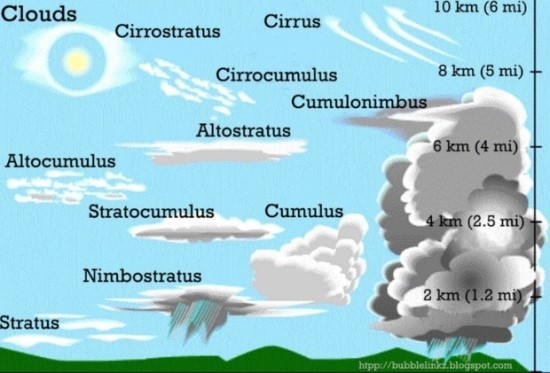

In [53]:
Image("구름.jpg")
#사진출처 https://blog.naver.com/bang9465/220965197506